In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

import prettytable as pt

import pydotplus
from sklearn.tree import export_graphviz

from sklearn.neighbors import NearestNeighbors

import seaborn as sns
from matplotlib.colors import ListedColormap

## 1. Data Input

In [75]:
def load_data():
    path = "./student-mat.csv" #指定路徑
    df = pd.read_csv(path, sep = ';') #透過';'把資料切成多個columns
    return df

In [76]:
df = load_data()

## 2. Data Preprocessing

In [77]:
def preprocessing(df):
    for index in df.keys():
        if type(df[index][0]) == type("str") or index == "G3": #如果當前 feature 不是 numerical 或現在的 column 是 G3(label)，則跳過
            continue
        df[index] = (df[index] - df[index].mean()) / df[index].std() #normalize

    df = pd.get_dummies(df) #one-hot encoding
    df = shuffle(df, random_state = np.random.RandomState(seed = 512)) #shuffle data
    return df

In [78]:
def get_y2(y):
    less_10 = [i for i in range(10)] #低於 10 數字的 list
    higher_or_eq_10 = [i for i in range(10, 21, 1)] #介在 10~20 數字的 list
    
    y_2 = y #把 y_2 assign 成 G3 這個 column
    y_2 = y_2.replace(less_10, 0) #若 G3 < 10，把值 assign 成 0
    y_2 = y_2.replace(higher_or_eq_10, 1) #若 10 <= G3 <= 20，把值 assign 成 1
    
    return y_2

In [79]:
def get_y5(y):
    F = [i for i in range(10)] # 0 <= F <= 9
    D = [10, 11] 
    C = [12, 13]
    B = [14, 15]
    A = [i for i in range(16, 21, 1)] # 16 <= A <= 20
    
    y_5 = y #把 y_5 assign 成 G3 這個 column
    y_5 = y_5.replace(F, 0) #若 G3 < 10，把值 assign 成 0
    y_5 = y_5.replace(D, 1) #若 G3 == 10 or G3 == 11，把值 assign 成 1
    y_5 = y_5.replace(C, 2) #若 G3 == 12 or G3 == 13，把值 assign 成 2
    y_5 = y_5.replace(B, 3) #若 G3 == 14 or G3 == 15，把值 assign 成 3
    y_5 = y_5.replace(A, 4) #若 16 <= G3 <= 20，把值 assign 成 4
    
    return y_5

In [80]:
df = preprocessing(df) #對 data 做 preprocessing
X = df.drop(columns = ['G3']) # 把 G3(label) drop 掉以後 assign 給 X
y = df['G3'] # 把 y assign 成 G3(label)

y_2 = get_y2(y) # binary classification
y_5 = get_y5(y) # 5-level classification

#把 DataFrame(X) 和 Series(y_2, y_5) 轉成 numpy array
X = X.to_numpy()
y_2 = y_2.to_numpy()
y_5 = y_5.to_numpy()

## 3. Principal components analysis (PCA)

In [81]:
def getPCA(X, n):
    pca = PCA(n_components = n, whiten = True, random_state = np.random.RandomState(seed = 1024)) #得到一個 PCA 的 object 
    PCA_X = pca.fit(X).transform(X) 
    return PCA_X

In [82]:
PCA_X = getPCA(X, 20) # 對 X 降維（降維到 20 維）

## 4. Model Construction

In [83]:
def decision_tree(X_train, y_train, draw):
    model = DecisionTreeClassifier(criterion = "gini", max_depth = 7, max_leaf_nodes = 10, random_state = np.random.RandomState(seed = 2048))
    #得到 decision tree 的 model
    
    model.fit(X_train, y_train)
    
    #畫出 decision tree 的圖
    if draw == 1:
        labels = ["fail", "pass"]
        dot_data = export_graphviz(model, out_file = None, class_names = labels)
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_pdf("decision_tree.pdf")
    
    return model

In [84]:
def random_forest(X_train, y_train, n):
    model = RandomForestClassifier(n_estimators = n, criterion = "gini", max_depth = 7, random_state = np.random.RandomState(seed = 2584))
    #得到 random forest 的 model
    
    model.fit(X_train, y_train)
    return model

In [85]:
def KNN(X_train, y_train, n):
    model = KNeighborsClassifier(n_neighbors = n) # 得到 KNN 的 model
    model.fit(X_train, y_train)
    return model

## 5. Validation

In [86]:
def k_fold(X, y, mode):
    k = 3
    kf = KFold(n_splits = k) #得到一個 k = 3 的 KFold object
    
    size = None
    
    #透過 mode 得知要做的是 binary classification 或 5-level classification
    if mode <= 5 or mode >= 12:
        size = 2
    else:
        size = 5
        
    draw = 0 # 這邊的 decision tree model 都不需要畫圖
        
    total_c_m = np.zeros((size, size))
    total_a_s, total_r_s, total_p_s =  0, 0, 0
    #initialize total confusion matrix, total accuracy, total recall, total precision

    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index] 
        #先把 training data 跟 testing data 分配好
        
        model = None
        
        if mode == 12:
            model = random_forest(X_train, y_train, 33) #建一個有 33 trees 的 random forest model
        elif mode == 13:
            model = random_forest(X_train, y_train, 17) #建一個有 17 trees 的 random forest model
        elif mode == 14:
            model = KNN(X_train, y_train, 7) #建一個 K = 7 的 KNN model
        elif mode == 15:
            model = KNN(X_train, y_train, 5) #建一個 K = 5 的 KNN model
        elif mode % 6 == 0 or mode % 6 == 1:
            model = decision_tree(X_train, y_train, draw) #建一個 decision tree model
        elif mode % 6 == 2 or mode % 6 == 3:
            model = random_forest(X_train, y_train, 65) #建一個有 65 trees 的 random forest model
        elif mode % 6 == 4 or mode % 6 == 5:
            model = KNN(X_train, y_train, 9) #建一個 K = 7 的 KNN model
            
        y_pred = model.predict(X_test) #透過 model 對 testing data 做預測
        c_m = confusion_matrix(y_test, y_pred) #得到 confusion matrix
        a_s = accuracy_score(y_test, y_pred) #得到 accuarcy
        r_s = recall_score(y_test, y_pred, average = None) #得到 recall
        p_s = precision_score(y_test, y_pred, average = None) #得到 precision
        
        total_c_m = total_c_m + c_m  #把 total confusion matrix 加上此次算出來的 confusion matrix
        total_a_s = total_a_s + a_s #把 total accuracy 加上此次算出來的 accuracy
        total_r_s = total_r_s + r_s #把 total recall 加上此次算出來的 recall
        total_p_s = total_p_s + p_s #把 total precision 加上此次算出來的 precision
        
    avg_c_m = np.round(total_c_m / k, 2) #算出平均 confusion matrix，並四捨五入到小數點第二位
    avg_a_s = round(total_a_s / k, 2) #算出平均 accuracy，並四捨五入到小數點第二位
    avg_r_s = np.round(total_r_s / k, 2) #算出平均 recall，並四捨五入到小數點第二位
    avg_p_s = np.round(total_p_s / k, 2) #算出平均 precision，並四捨五入到小數點第二位

    model_name = None
    with_without = None
    classification = None
    
    #設定 model 的名字
    if mode == 12:
        model_name = "Random Forest(33 trees)"
    elif mode == 13:
        model_name = "Random Forest(17 trees)"
    elif mode == 14:
        model_name = "KNN(K = 7)"
    elif mode == 15:
        model_name = "KNN(K = 5)"
    elif mode % 6 == 0 or mode % 6 == 1:
        model_name = "Decision Tree"
    elif mode % 6 == 2 or mode % 6 == 3:
        model_name = "Random Forest(65 trees)"
    else:
        model_name = "KNN(K = 9)"
        
    #設定有沒有做 PCA
    if mode % 2 == 0 or mode >= 12:
        with_without = "without"
    else:
        with_without = "with"

    #設定是 binary classification 還是 5-level classification
    if mode <= 5 or mode >= 12:
        classification = "Binary Classification"
    else:
        classification = "5-level Classification"
    
    method = "{} {} PCA ({})".format(model_name, with_without, classification) # assign method 
    
    # 設定 k_list 的形式
    k_list = None
    if mode <= 5 or mode >= 12:
        k_list = [method, avg_a_s, avg_r_s[0], avg_r_s[1], "/", "/", "/", 
                  avg_p_s[0], avg_p_s[1], "/", "/", "/"]
    #把 method name, 平均 accuracy, 平均 recall （根據 label 分類）, 平均 precision （根據 label 分類） 塞進 k_list 中
    
    else:
        k_list = [method, avg_a_s, avg_r_s[0], avg_r_s[1], avg_r_s[2], avg_r_s[3], avg_r_s[4], 
                  avg_p_s[0], avg_p_s[1], avg_p_s[2], avg_p_s[3], avg_p_s[4]]
    #把 method name, 平均 accuracy, 平均 recall （根據 label 分類）, 平均 precision （根據 label 分類） 塞進 k_list 中

    c_m_list = [method, avg_c_m] #把 method name 和 平均 confusion matrix 塞進 c_m_list 中
    return c_m_list, k_list 

## 6. Results

In [109]:
#得到每種 method 對應的 c_m_list, k_list
d_no_2_c_m, d_no_2_list = k_fold(X, y_2, 0)
d_wi_2_c_m, d_wi_2_list = k_fold(PCA_X, y_2, 1)
r_no_2_c_m, r_no_2_list = k_fold(X, y_2, 2)
r_wi_2_c_m, r_wi_2_list = k_fold(PCA_X, y_2, 3)
K_no_2_c_m, K_no_2_list = k_fold(X, y_2, 4)
K_wi_2_c_m, K_wi_2_list = k_fold(PCA_X, y_2, 5)

d_no_5_c_m, d_no_5_list = k_fold(X, y_5, 6)
d_wi_5_c_m, d_wi_5_list = k_fold(PCA_X, y_5, 7)
r_no_5_c_m, r_no_5_list = k_fold(X, y_5, 8)
r_wi_5_c_m, r_wi_5_list = k_fold(PCA_X, y_5, 9)
K_no_5_c_m, K_no_5_list = k_fold(X, y_5, 10)
K_wi_5_c_m, K_wi_5_list = k_fold(PCA_X, y_5, 11)

r_no_2_c_m_2, r_no_2_list_2 = k_fold(X, y_2, 12)
r_no_2_c_m_3, r_no_2_list_3 = k_fold(X, y_2, 13)

K_no_2_c_m_2, K_no_2_list_2 = k_fold(X, y_2, 14)
K_no_2_c_m_3, K_no_2_list_3 = k_fold(X, y_2, 15)

#把所有 k_list 塞進 all_list 中
all_list = [d_no_2_list, d_wi_2_list, r_no_2_list, r_no_2_list_2, r_no_2_list_3, r_wi_2_list, K_no_2_list, K_no_2_list_2,
            K_no_2_list_3, K_wi_2_list, d_no_5_list, d_wi_5_list, r_no_5_list, r_wi_5_list, K_no_5_list, K_wi_5_list]

title_list =  ["Method", "Accuracy", "Recall(fail or F)", "Recall(pass or D)",
                     "Recall(C)", "Recall(B)", "Recall(A)", "Precision(fail or F)",
                     "Precision(pass or D)", "Precision(C)", "Precision(B)", 
                     "Precision(A)"] #把各個 column 名稱定好

table = pd.DataFrame(all_list, columns = title_list) #把 table 用 DataFrame 顯示出來
pd.set_option("display.max_colwidth", 10000) #設定 DataFrame column 的最大寬度
table # 顯示 table

,Method,Accuracy,Recall(fail or F),Recall(pass or D),Recall(C),Recall(B),Recall(A),Precision(fail or F),Precision(pass or D),Precision(C),Precision(B),Precision(A)
0,Decision Tree without PCA (Binary Classification),0.91,0.87,0.93,/,/,/,0.86,0.94,/,/,/
1,Decision Tree with PCA (Binary Classification),0.79,0.61,0.89,/,/,/,0.72,0.82,/,/,/
2,Random Forest(65 trees) without PCA (Binary Classification),0.91,0.87,0.93,/,/,/,0.86,0.94,/,/,/
3,Random Forest(33 trees) without PCA (Binary Classification),0.91,0.88,0.93,/,/,/,0.87,0.94,/,/,/
4,Random Forest(17 trees) without PCA (Binary Classification),0.91,0.85,0.94,/,/,/,0.88,0.93,/,/,/
5,Random Forest(65 trees) with PCA (Binary Classification),0.85,0.65,0.96,/,/,/,0.87,0.85,/,/,/
6,KNN(K = 9) without PCA (Binary Classification),0.82,0.55,0.95,/,/,/,0.84,0.81,/,/,/
7,KNN(K = 7) without PCA (Binary Classification),0.80,0.55,0.93,/,/,/,0.80,0.81,/,/,/
8,KNN(K = 5) without PCA (Binary Classification),0.80,0.56,0.92,/,/,/,0.78,0.81,/,/,/
9,KNN(K = 9) with PCA (Binary Classification),0.72,0.32,0.92,/,/,/,0.67,0.74,/,/,/


> **Random Forest:** 我在 binary classification 中測試了 **65, 33, 17 trees**（選奇數才不會導致有平手的狀況），可以看到三者的 accuracy 相等。<br>
fail 的 recall 在 **tree = 33 時最高**。pass 的 recall 在 **tree = 17* 時最高**。<br>
fail 的 precision 隨著 **tree 下降而上升**，pass 的 precision 在 **tree = 17** 時最低
 
> **Difference between K-fold cross-validation and Random Forest:** Random Forest 是在 **training data** 中再去隨機取樣，並且也有可能會隨機取 feature；K-fold cross-validation 則是在**所有data中**(m 筆)取**連續**的 m/k 筆 data 當成 validation set，並且每個 feature 都會取到。 

> **KNN:** 我在 binary classification 中測試了 **K = 9, K = 7, K = 5** 這三種情況（選奇數才不會導致有平手的狀況），可以看到正確率在 **K = 9 時最大**。<br>
而在 recall 方面，fail 的 recall **隨著 K 下降而上升**；相反地，pass 的 recall **隨著 K 上升而上升**。 <br>
precision 則和 recall 相反，fail 的 precision **隨著 K 上升而上升**，pass 的 precision 則**沒有變化**。

>做過 PCA 的資料 performance 都變得更差，我想可能是我的 PCA 做錯了。

In [88]:
#把所有的 c_m_list 塞進 all_c_m_list 中
all_c_m_list = [d_no_2_c_m, d_wi_2_c_m, r_no_2_c_m, r_wi_2_c_m, K_no_2_c_m, K_wi_2_c_m, 
             d_no_5_c_m, d_wi_5_c_m, r_no_5_c_m, r_wi_5_c_m, K_no_5_c_m, K_wi_5_c_m]

c_m_table = pt.PrettyTable() #建一個 PrettyTable
c_m_table.field_names = ["Method", "Confusion Matrix"] #設定 column 的名稱

for c_m in all_c_m_list:
    c_m_table.add_row(c_m) # 把資料放進 row 中
    c_m_table.add_row([" ", " "]) # 加一個空的 row（否則會太擠）

print(c_m_table) #顯示 table

+--------------------------------------------------------------+-----------------------------------+
|                            Method                            |          Confusion Matrix         |
+--------------------------------------------------------------+-----------------------------------+
|      Decision Tree without PCA (Binary Classification)       |           [[37.67  5.67]          |
|                                                              |           [ 6.   82.33]]          |
|                                                              |                                   |
|        Decision Tree with PCA (Binary Classification)        |           [[26.33 17.  ]          |
|                                                              |           [10.   78.33]]          |
|                                                              |                                   |
| Random Forest(65 trees) without PCA (Binary Classification)  |           [[37.67  5.67]  

## 7. Comparison & Conclusion

* 可以看到 binary classification 正確率遠高於 5-level classification，蠻合理的
* 在 binary classification 中，不管是 recall 還是 precision 幾乎都是 pass 表現較好，我推測是因為 pass 的人比 fail 的人多（請看下code）

In [89]:
zero, one = 0, 0

for y in y_2:
    if y == 0: # 如果 label == 0 (fail)
        zero += 1 # zero 就加一
    else:
        one += 1 # 否則就是 one 加一
        
print("pass: {}, fail: {}".format(one, zero)) #顯示 pass 人數、fail 人數

pass: 265, fail: 130


* 在 5-level classification 中， recall 和 precision 幾乎都是 F 的表現最好，有可能是因為資料最多的關係（請看下code）。但應該不只是這個原因，因為其他的資料並沒有因為資料量較多而表現較好

In [90]:
A, B, C, D, F = 0, 0, 0, 0, 0

#根據 label 把對應的 counter + 1 
for y in y_5:
    if y == 0:
        F += 1
    elif y == 1:
        D += 1
    elif y == 2:
        C += 1
    elif y == 3:
        B += 1
    elif y == 4:
        A += 1
        
print("A: {}, B: {}, C: {}, D: {}, F: {}".format(A, B, C, D, F)) #顯示 A 人數、B 人數、C 人數、D 人數、F 人數

A: 40, B: 60, C: 62, D: 103, F: 130


## 8. Questions 

### Decision Tree
* Show the prediction and reasoning of one arbitrary sample in the testing set.

In [91]:
train_size = len(PCA_X) // 3 * 2 # 決定 training data 的 size
PCA_X_train = PCA_X[:train_size] # training data 用第 0 筆 ~ 第 (train_size - 1) 筆 data  
y_2_train = y_2[:train_size] # training data 對應的 label
model =  decision_tree(PCA_X_train, y_2_train, 1) #透過 training data 和 label 得到一個 decision tree model，並且要畫圖 (draw = 1)

In [110]:
data = pd.Series(PCA_X[-1]) # 拿整個 data 的最後一筆當作 testing data
data # 顯示 data

0    -0.398799
1     1.997241
2     1.467473
3     2.046383
4     0.254952
5    -1.205209
6     0.862413
7     0.803877
8     0.712709
9    -0.810763
10   -0.156522
11    1.384166
12   -0.036588
13   -0.543233
14   -0.770162
15   -0.691706
16   -0.318763
17    1.192286
18    2.546557
19   -1.359459
dtype: float64

* 使用這筆 data 當作 input，在 decision tree 上的 prediction 如下圖

![avatar](https://raw.githubusercontent.com/ee-chiu/ML-hw2/master/decision_tree.png)

> **解釋**: <br> 1. data[0] = -0.398799 <= 0.154，走 True <br> 2. data[2] = 1.467473 > -1.083，走 False <br> 3. leaf node 的 class 是 pass，所以這筆 data 的 prediction 會是 pass

### Random Forest
* Describe the difference between boosting and bagging.

1. 抽樣
    * **bagging**: 各個 data 被抽到的機率是相等的
    * **boosting**: 每次抽取的 data 是透過前一次的 model 預測結果來調整抽到的機率（錯誤率越高，機率越高）


2. 各個 decision tree 權重
    * **bagging**: 每個 decision tree 的權重都是相等的
    * **boosting**: decision tree 的正確率越高，權重越大


3. 平行運算
    * **bagging**: 可以平行運算（因為各個 decision tree 獨立）
    * **boosting**: 不可平行運算（因為每個 decision tree 都會根據前一個預測結果調整抽取 data 的機率）


4. 用途
    * **bagging**: 降低 variance
    * **boosting**: 降低 bias

### KNN
* Show the prediction and reasoning of one arbitrary sample in the testing set.

In [93]:
train_size = len(PCA_X) // 3 * 2 # 決定 training data 的 size 
PCA_X_train = PCA_X[:train_size] # training data 用第 0 筆 ~ 第 (train_size - 1) 筆 data 
y_2_train = y_2[:train_size] # training data 對應的 label

neighbors = NearestNeighbors(n_neighbors = 9) #得到一個 NearestNeighbors 的 object
neighbors.fit(PCA_X_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                 radius=1.0)

In [94]:
data = pd.Series(PCA_X[-2]) # 拿整個 data 的倒數第二筆當作 testing data
data # 顯示 data

0     0.546563
1     0.143611
2     1.470757
3    -0.096565
4    -0.467588
5    -0.360328
6     2.340002
7     0.530250
8    -1.072656
9    -0.472542
10   -2.768266
11    0.519489
12   -0.384848
13    1.643703
14    1.096301
15    1.074034
16   -1.548772
17   -0.856279
18    3.360494
19    1.252344
dtype: float64

* 使用這筆 data 當作 input

In [95]:
data = data.to_numpy() # 把 Series 轉成 numpy array
data = data.reshape(1, -1) # 把 shape 改成只有一個 row

distances, indices = neighbors.kneighbors(data) # 透過上面得到的 NearestNeighbors object 得到當前 data 的 k 個 neighbors 的 distance 和 index
for i in range(len(indices[0])):
    print("distance: {}, label: {}".format(round(distances[0][i], 5), y_2_train[indices[0][i]])) 
    #顯示每個 neighbors 和 當前 data 的 distance 和 label

distance: 5.26965, label: 0
distance: 5.31836, label: 1
distance: 5.68956, label: 1
distance: 5.74586, label: 1
distance: 5.78061, label: 1
distance: 5.78374, label: 1
distance: 5.99098, label: 0
distance: 6.04845, label: 1
distance: 6.05017, label: 1


In [96]:
np.argmax(np.bincount(y_2_train[indices[0, :]])) # 得到鄰居中最多的 label

1

* 因此這筆 data 的預測值為 1 (pass)

### KNN
* Bonus: pick 2 features, draw and describe the KNN decision boundaries.

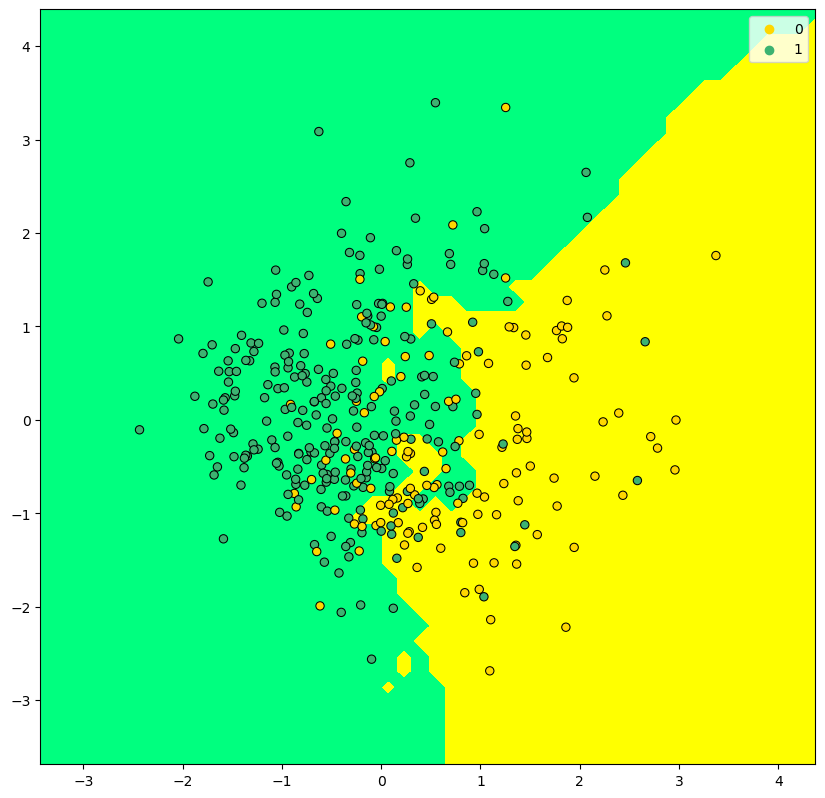

In [108]:
PCA_X_2 = getPCA(X, 2) # 把 X 用 PCA 降到二維
model = KNN(PCA_X_2, y_2, 9) #得到 K = 9 的 KNN model

x_min, x_max = PCA_X_2[:, 0].min() - 1, PCA_X_2[:, 0].max() + 1 #得到第一個 dimension 的 min 跟 max
y_min, y_max = PCA_X_2[:, 1].min() - 1, PCA_X_2[:, 1].max() + 1 #得到第二個 dimension 的 min 跟 max
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50)) # 得到兩個 50x50 的 matrix

Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # 透過 model 預測結果 Z
Z = Z.reshape(xx.shape) # 把 Z reshape，等等畫圖才畫得上去

plt.figure(figsize=(10, 10), dpi = 100) #決定 figure size 跟 解析度

plt.contourf(xx, yy, Z, cmap = ListedColormap(["yellow", "springgreen"])) # 畫出底色

sns.scatterplot(x = PCA_X_2[:, 0], y = PCA_X_2[:, 1], hue = y_2,
                palette = ["gold", "mediumseagreen"], alpha=1.0, edgecolor = "black") # 把 data 的點畫上去( 0 是 fail, 1 是 pass )（不知道為什麼把 label 標上去的話顏色會相反，所以就用 0,1 表示了）

plt.xlim(xx.min(), xx.max()) # 決定 x 軸的上下限
plt.ylim(yy.min(), yy.max()) # 決定 y 軸的上下限

plt.show() # 顯示圖片

### PCA
* In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot. You have to colorize the data points based on their labels.

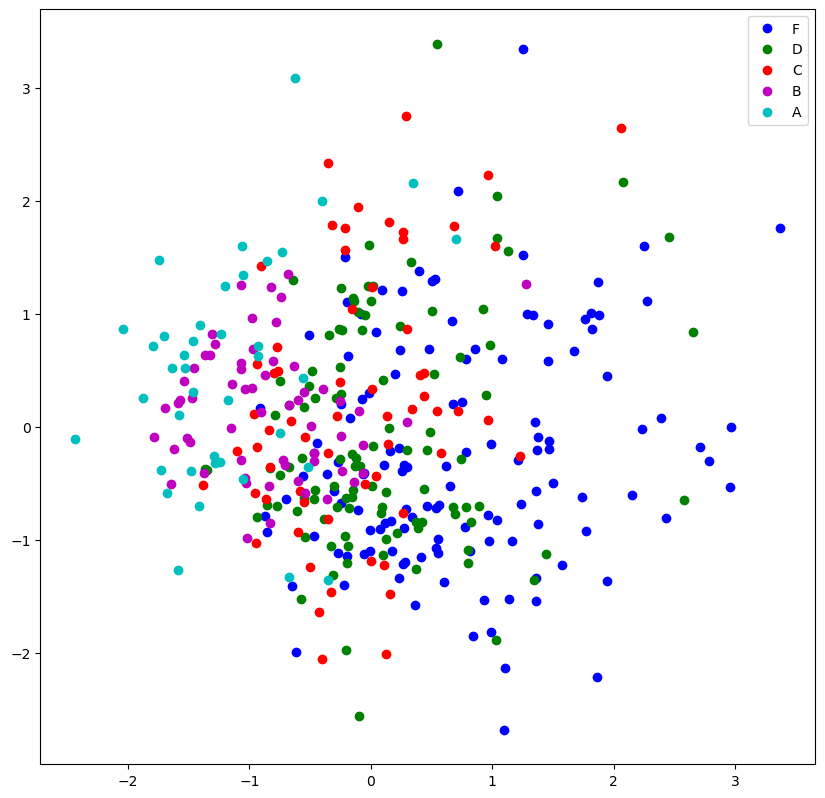

In [98]:
PCA_X_2 = getPCA(X, 2) # 把 feature 透過 PCA 降到二維
dim1 = PCA_X_2[:, 0] # 得到第一個 dimension 的資料
dim2 = PCA_X_2[:, 1] # 得到第二個 dimension 的資料

F_dim1 = []
F_dim2 = []
D_dim1 = []
D_dim2 = []
C_dim1 = []
C_dim2 = []
B_dim1 = []
B_dim2 = []
A_dim1 = []
A_dim2 = []

#記錄各個 label 的 dimension 資料
for i in range(len(dim1)):
    if y_5[i] == 0:
        F_dim1.append(dim1[i])
        F_dim2.append(dim2[i])
    elif y_5[i] == 1:
        D_dim1.append(dim1[i])
        D_dim2.append(dim2[i])
    elif y_5[i] == 2:
        C_dim1.append(dim1[i])
        C_dim2.append(dim2[i])
    elif y_5[i] == 3:
        B_dim1.append(dim1[i])
        B_dim2.append(dim2[i])
    elif y_5[i] == 4:
        A_dim1.append(dim1[i])
        A_dim2.append(dim2[i])

plt.figure(figsize=(10, 10), dpi = 100) # 決定圖片大小和解析度
        
#根據 label 畫圖
plt.plot(F_dim1, F_dim2, 'bo', label = 'F') 
plt.plot(D_dim1, D_dim2, 'go', label = 'D')
plt.plot(C_dim1, C_dim2, 'ro', label = 'C')
plt.plot(B_dim1, B_dim2, 'mo', label = 'B')
plt.plot(A_dim1, A_dim2, 'co', label = 'A')

plt.legend() # 顯示圖例
plt.show() # 顯示圖片